In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
file = open("/content/drive/MyDrive/Introduction to Bioinformatics/Project Proposal/Dataset/histone/H3K4me2.txt","r")
sequences = []
class_label = []
for line in file:
    if '>' in line:
        continue
    line = line[:-1]
    if len(line)>1:
        sequences.append(line)
    else:
        class_label.append(int(line)) 
file.close()
removable = []
for i in range(len(sequences)):
    if len(sequences[i]) < 500:
        print(len(sequences[i]))
        removable.append(i)

iter = 0
for x in removable:
    sequences.pop(x-iter)
    class_label.pop(x-iter)
    iter+=1

one = 0
zero = 0
for c in class_label:
    if c == 0:
        zero+=1
    else:
        one+=1
print(zero, one)
print(zero/(zero+one))
print(one/(zero+one))
class_label = np.array(class_label)

310
290
12539 18142
0.4086894169029693
0.5913105830970308


In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Dropout, SpatialDropout1D, Bidirectional, Flatten
from keras.layers.recurrent import LSTM

In [ ]:
def SeqtoSen(sequences):
    sentences = []
    for sequence in sequences:
        sentence = ""
        for i in range(len(sequence)-2):
            if (len(sentence)>0):
                sentence = sentence + " ";
            sentence = sentence + sequence[i:i+3]
        sentences.append(sentence)
    return sentences

In [ ]:
sentences = ['CATGTAGTATTGGGC']
print(SeqtoSen(sentences))

['CAT ATG TGT GTA TAG AGT GTA TAT ATT TTG TGG GGG GGC']


In [ ]:
sequences = SeqtoSen(sequences)

In [ ]:
import numpy as np

vocab_size = 64
encoded_docs = [one_hot(sequence, vocab_size) for sequence in sequences]
for i in range(len(encoded_docs)):
    encoded_docs[i] = np.array(encoded_docs[i])
encoded_docs = np.array(encoded_docs)

In [ ]:
def get_model():
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = 256, input_length=498))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(units=256,return_sequences = True)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef

es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=200)
mc = ModelCheckpoint('best_model.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True, save_weights_only=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 498, 256)          16384     
                                                                 
 spatial_dropout1d (SpatialD  (None, 498, 256)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 498, 512)         1050624   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 254976)            0         
                                                                 
 dense (Dense)               (None, 128)               32637056  
                                                                 
 dropout (Dropout)           (None, 128)               0

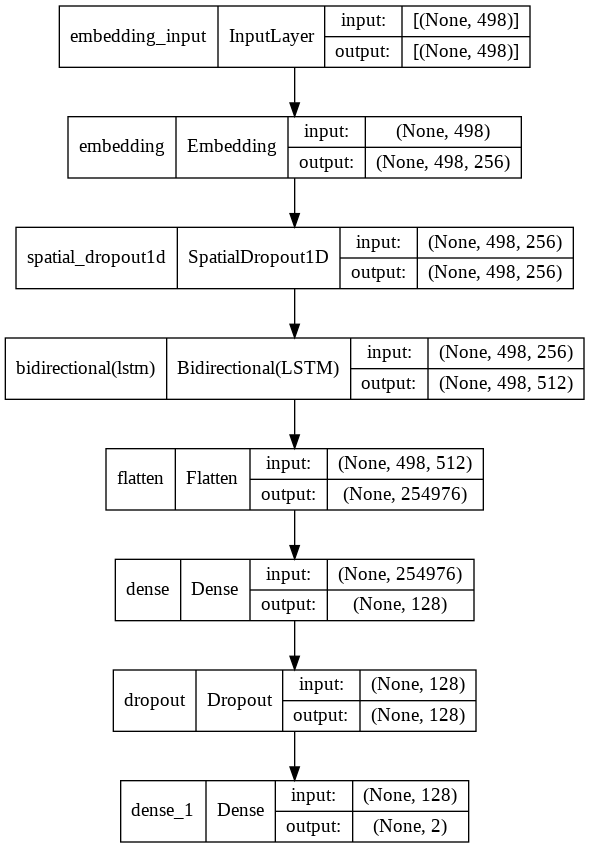

In [ ]:
from keras.utils.vis_utils import plot_model
model = get_model()
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(encoded_docs, class_label, train_size = 0.8, random_state=42, stratify=class_label)
train_X, val_X, train_y, val_y = train_test_split(X_train_val, y_train_val, train_size = 0.9, random_state = 42, stratify=y_train_val)
model.fit(train_X,train_y, validation_data=(val_X,val_y), epochs=300,batch_size=256,callbacks=[es,mc])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 498, 256)          16384     
                                                                 
 spatial_dropout1d_10 (Spati  (None, 498, 256)         0         
 alDropout1D)                                                    
                                                                 
 bidirectional_8 (Bidirectio  (None, 498, 512)         1050624   
 nal)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 254976)            0         
                                                                 
 dense_13 (Dense)            (None, 128)               32637056  
                                                                 
 dropout_6 (Dropout)         (None, 128)             

In [ ]:
model.load_weights('best_model.h5')
p = model.predict(X_test)
prediction = []
for x in p:
    if(x[0]>x[1]):
        prediction.append(0)
    else:
        prediction.append(1)

f = open(output_file, "w")
f.write(f'Accuracy: {accuracy_score(y_test,prediction)}\n')
f.write(f'Precision: {precision_score(y_test,prediction)}\n')
f.write(f'Recall: {recall_score(y_test,prediction)}\n')
f.write(f'F1 Score: {f1_score(y_test,prediction)}\n')
f.write(f'MCC Score: {matthews_corrcoef(y_test,prediction)}\n')
f.close()